#### 自作モジュールの参照先を上書き

In [1]:
import sys

parent_dir = 'Predict-Future-Sales'
p_sub = sys.path[0]

ride = ''
for path in p_sub.split('/'):
    if path != parent_dir:
        ride = ride + path + '/'
    else:
        ride = ride + path + '/'
        break
sys.path[0] = ride

In [2]:
import pickle

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt

from module.lino_module.preprocess import time_series_dataset
from module.lino_module.model import TransformerModel

/Users/lino/opt/anaconda3/envs/for_pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## データセットの準備

In [3]:
data = pd.read_csv('../data/sales_train.csv')
seq = 7
d_model = 64
dilation = 1
train, test = time_series_dataset(data, seq=seq, d_model=d_model, dilation=dilation)

## 訓練用モデルの準備

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
nhead=8
transformer = TransformerModel(d_model, nhead).to(device)
criterion = nn.MSELoss()
optimizer = Adam(transformer.parameters(), lr=1e-5, betas=(0.95, 0.98), eps=10e-9)

## モデル訓練

In [5]:
epoch = 100
train_loss = []
test_loss = []
for i in range(epoch):
    print(f' epoch_{i} '.center(50, '-'))
    train_epoch_loss = []
    test_epoch_loss = []
    for i, pack in enumerate(train):
        src, tgt, y = [i.to(device) for i in pack]
        # モデル訓練
        if i == 0:
            pass
        else:
            cached_src, cached_tgt, cached_y = cach
            transformer.train()
            optimizer.zero_grad()
            output = transformer(cached_src, cached_tgt)
            loss = criterion(output[:, 1, :], cached_y)
            train_epoch_loss.append(loss.item())
            # 勾配計算
            loss.backward()
            optimizer.step()
            print(loss)

        # モデル評価
        transformer.eval()
        output = transformer(src, tgt)
        loss = criterion(output[:, 1, :], y)
        test_epoch_loss.append(loss.item())
        # 訓練用データをキャッシュとに保存して次回の訓練データにする
        cach = (src, tgt, y)

    test_loss.append(torch.mean(torch.tensor(test_epoch_loss)))
    try:
        train_loss.append(torch.mean(torch.tensor(train_epoch_loss)))
    except:
        pass

-------------------- epoch_0 ---------------------
tensor(1.1715, grad_fn=<MseLossBackward0>)
tensor(0.7989, grad_fn=<MseLossBackward0>)
tensor(0.5690, grad_fn=<MseLossBackward0>)
tensor(0.9812, grad_fn=<MseLossBackward0>)
tensor(2.7850, grad_fn=<MseLossBackward0>)
tensor(0.9374, grad_fn=<MseLossBackward0>)
tensor(1.0288, grad_fn=<MseLossBackward0>)
tensor(0.8470, grad_fn=<MseLossBackward0>)
tensor(1.0948, grad_fn=<MseLossBackward0>)
tensor(0.7391, grad_fn=<MseLossBackward0>)
tensor(2.3760, grad_fn=<MseLossBackward0>)
tensor(1.0695, grad_fn=<MseLossBackward0>)
tensor(1.5468, grad_fn=<MseLossBackward0>)
-------------------- epoch_1 ---------------------
tensor(0.7346, grad_fn=<MseLossBackward0>)
tensor(0.5127, grad_fn=<MseLossBackward0>)
tensor(0.4056, grad_fn=<MseLossBackward0>)
tensor(1.1137, grad_fn=<MseLossBackward0>)
tensor(3.4506, grad_fn=<MseLossBackward0>)
tensor(0.9210, grad_fn=<MseLossBackward0>)
tensor(0.6124, grad_fn=<MseLossBackward0>)
tensor(0.2795, grad_fn=<MseLossBackwar

### 訓練データの損失と検証データの損失
検証データの方が損失が小さい  
attentionマスクを実装していないためカンニングしている恐れあり

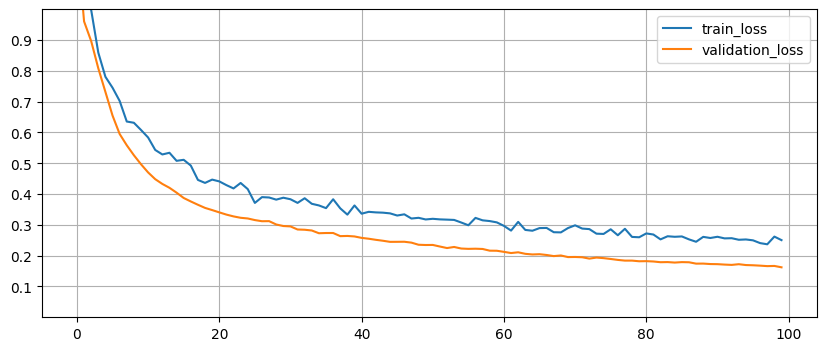

In [6]:
plt.figure(figsize=(10, 4))
plt.plot(train_loss, label=('train_loss'))
plt.plot(test_loss, label='validation_loss')
plt.legend()
plt.yticks([round(i*1e-1, 1) for i in range(1, 10)])
plt.grid(axis='x')
plt.grid(axis='y')
plt.ylim(0, 1)
img_path = '../osada_notebook/img/'
plt.savefig(img_path + f'Loss(epoch{epoch}_dmodel{d_model}_dilation{dilation}).png')
plt.show()

### 訓練データとテストデータでそれぞれを予測してみる

In [7]:
transformer.eval()
train_preds = []
for src, tgt, _ in train:
    train_pred = transformer(src, tgt)
    train_preds.append(train_pred[:, -1])

transformer.eval()
test_preds = []
for src, tgt, _ in test:
    test_pred = transformer(src, tgt)
    test_preds.append(test_pred[:, -1])

train_loss[-1], test_loss[-1]

(tensor(0.2505), tensor(0.1622))

In [8]:
import datetime
from module.lino_module.preprocess import _mode_of_freq

tag = _mode_of_freq(data).item_cnt_day
lag = d_model * dilation + seq

train_pred = torch.concat(train_preds).reshape(-1).detach().numpy()
test_pred = torch.concat(test_preds).reshape(-1).detach().numpy()

In [9]:
tr_start = tag.index[0] + datetime.timedelta(lag)
tr_end = tr_start + datetime.timedelta(len(train_pred) - 1)
tr_idx = pd.date_range(tr_start, tr_end)
train_time_series = pd.Series(train_pred, index=tr_idx)

te_start = tr_end + datetime.timedelta(1)
te_end = te_start + datetime.timedelta(len(test_pred) - 1)
te_idx = pd.date_range(te_start, te_end)
test_time_series = pd.Series(test_pred, index=te_idx)

In [10]:
test_trg = _mode_of_freq(data).item_cnt_day
test_trg = test_trg.values.reshape(-1,1)
src = StandardScaler().fit(test_trg)

In [11]:
tag_values = src.transform(tag.values.reshape(-1, 1)).reshape(-1)
tag_time_series = pd.Series(tag_values, tag.index)

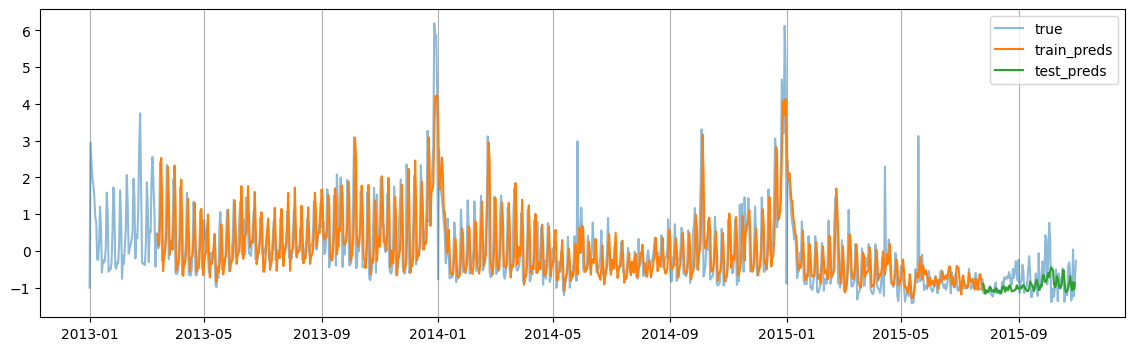

In [12]:
plt.figure(figsize=(14, 4))
plt.plot(tag_time_series, alpha=0.5, label='true')
plt.plot(train_time_series, label='train_preds')
plt.plot(test_time_series, label='test_preds')
plt.grid(axis='x')
plt.legend()

plt.savefig(img_path + f'Predict(epoch{epoch}_d_model{d_model}_dilation{dilation}).png')
plt.show()